<a href="https://colab.research.google.com/github/jungsh210/AI-Project/blob/main/Segmentation/Segmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-8l8aqj0k
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-8l8aqj0k
  Resolved https://github.com/tensorflow/examples.git to commit a55d94841a9cbf7b3b77d35bf81189fc6010dcc5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1688024567.944070384060361013435054447535562198627925417157-py3-none-any.whl size=301568 sha256=512b20a59736ae3022758b23f5d569132754f018bd29d7d86fc4e1a7f50aac53
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmzc6vcd/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Oxford-IIIT Pets 데이터 세트 다운로드

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLVY993/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLVY993/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
# TensorFlow Datasets (TFDS)를 사용하여 'oxford_iiit_pet' 데이터셋을 로드하는 코드
# 'tfds.load()' 함수는 TensorFlow Datasets에서 데이터셋을 로드하는 함수
# 'with_info=True'는 데이터셋의 메타 정보도 함께 로드하라는 의미
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

- 이미지 색상 값은 [0, 1] 범위로 정규화
- mask 픽셀에는 {1,2,3}이라는 레이블이 저장
- 편의를 위해 세분화 mask에서 1을 빼면 {0,1,2}와 같은 레이블이 생성

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

- 데이터 세트에는 이미 필요한 훈련 및 테스트 분할이 포함(동일한 분할을 계속 사용)

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

- 다음 클래스는 이미지를 무작위로 뒤집어 간단한 증강을 수행

In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

- 입력을 일괄 처리한 후 증강을 적용하여 입력 파이프라인을 빌드

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

- 데이터 세트에서 이미지 예제와 해당 mask를 시각화

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

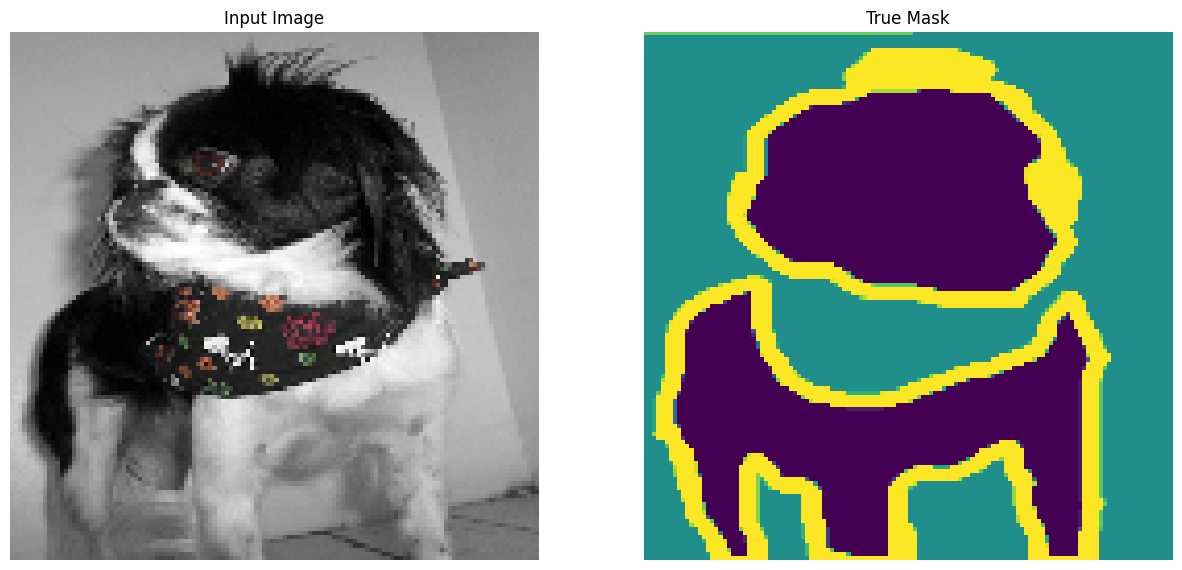

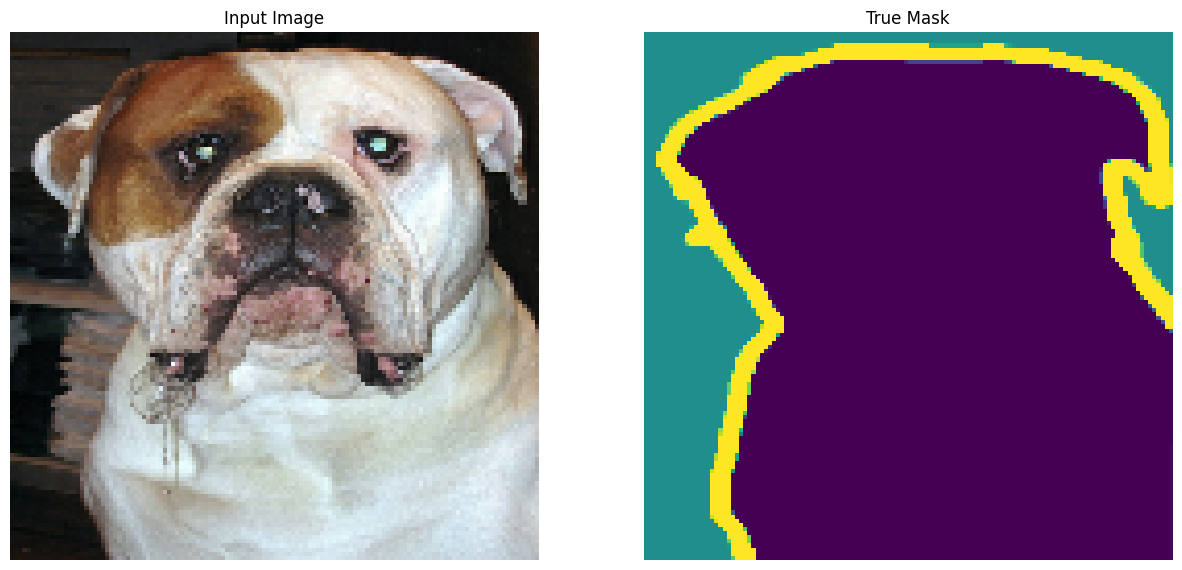

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## 모델 정의하기
- 여기에 사용된 모델은 :  U-Net
- U-Net은 Encoder와 Decoder로 구성
- 현재 Encoder는 사전 학습된 MobileNetV2 모델
- tf.keras.applications의 모델 사용

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


- Decoder/upsampler는 TesorFlow 예제에서 구현된 일련의 upsample 블록

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## 모델 훈련하기
- 레이블은 모든 클래스의 각 픽셀에 대한 점수 벡터가 아니라 정수 스칼라
- 따라서 **from_logits** 인수가 **True**로 설정된 **tf.keras..losses.CategoricalCrossentropy** 손실함수 사용

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

- 결과적인 모델 architecture를 플로팅

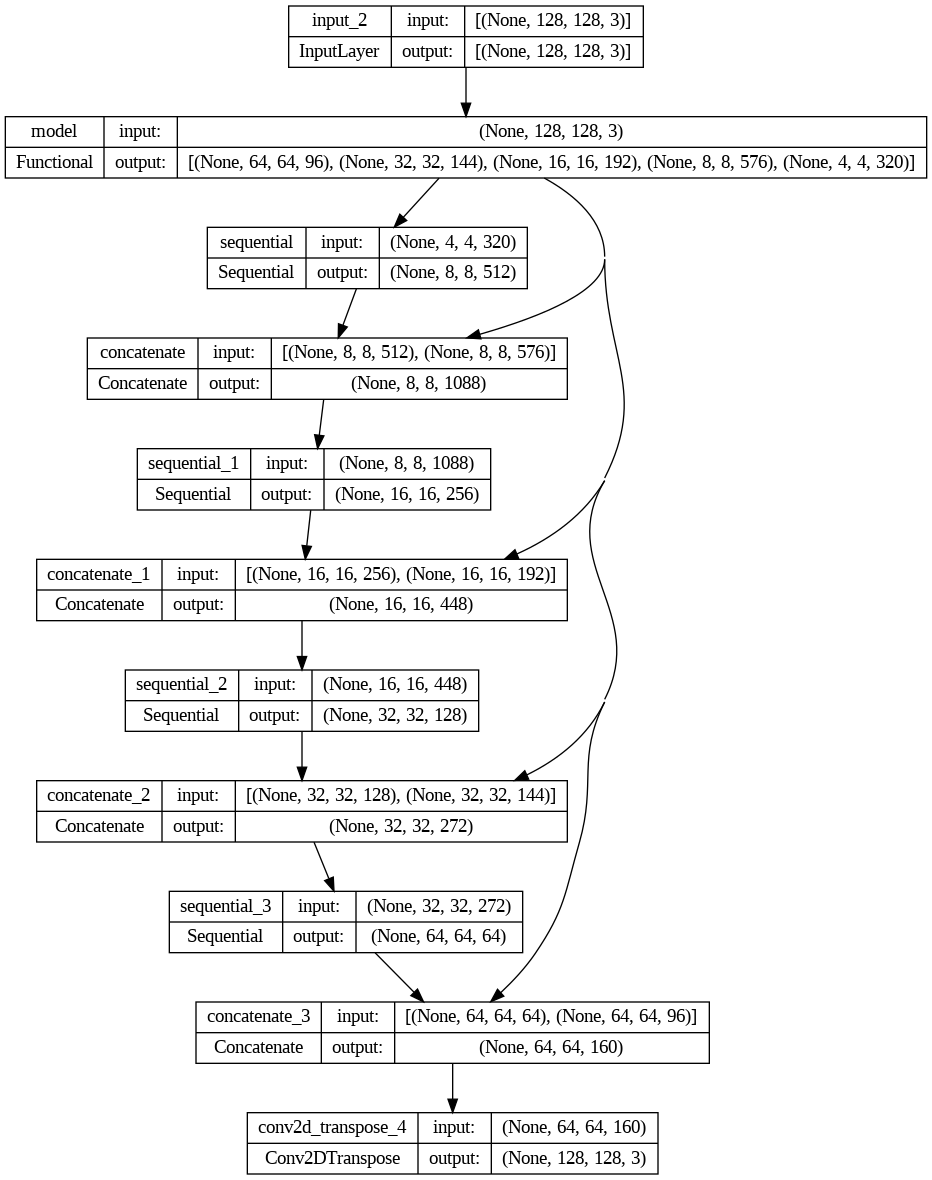

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

- 훈련 전에 모델이 예측하는 것을 확인하기 위해 모델을 시험

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 10s 10s/step


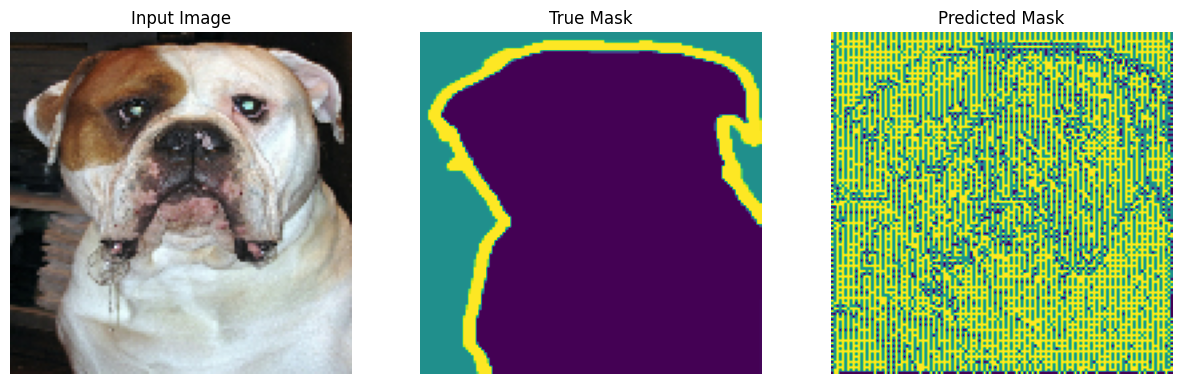

In [21]:
show_predictions()

- 아래에 정의된 콜백은 모델이 훈련되는 동안 어떻게 개선되는지 관찰하는 데 사용

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 26ms/step


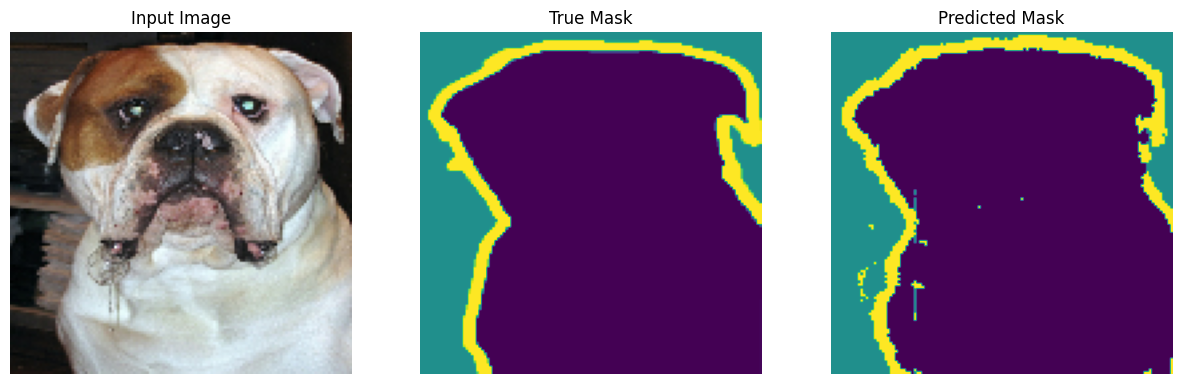


Sample Prediction after epoch 5

57/57 [==============================] - 13s 221ms/step - loss: 0.2567 - accuracy: 0.8921 - val_loss: 0.2759 - val_accuracy: 0.8896


In [24]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

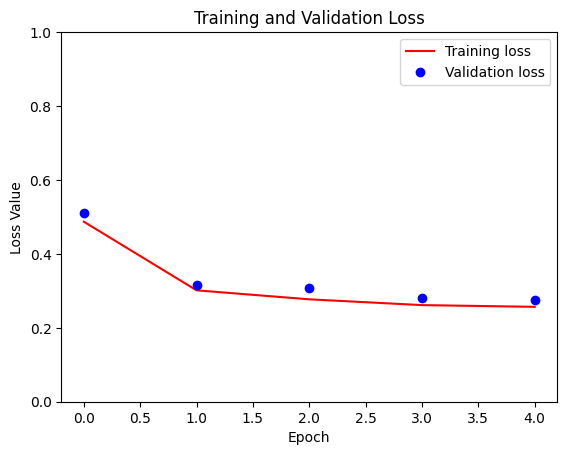

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 예측하기
- 시간 절약을 위해 epoch 수를 작게 유지
- 더 정확한 결과를 얻으려면 이 값을 더 높게 설정

2/2 [==============================] - 0s 78ms/step


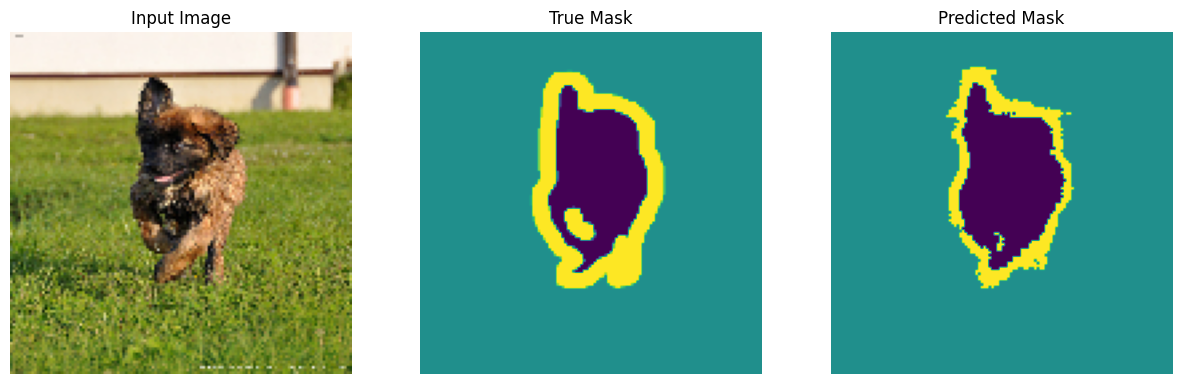

2/2 [==============================] - 0s 68ms/step


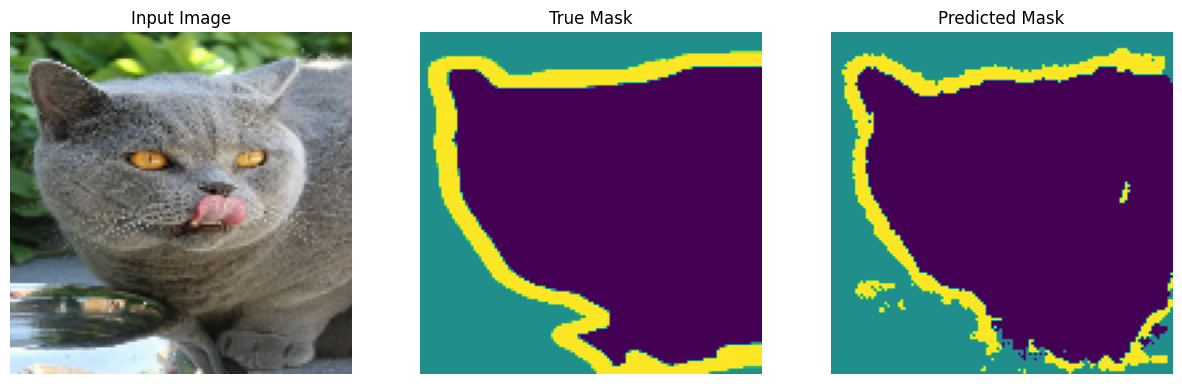

2/2 [==============================] - 0s 41ms/step


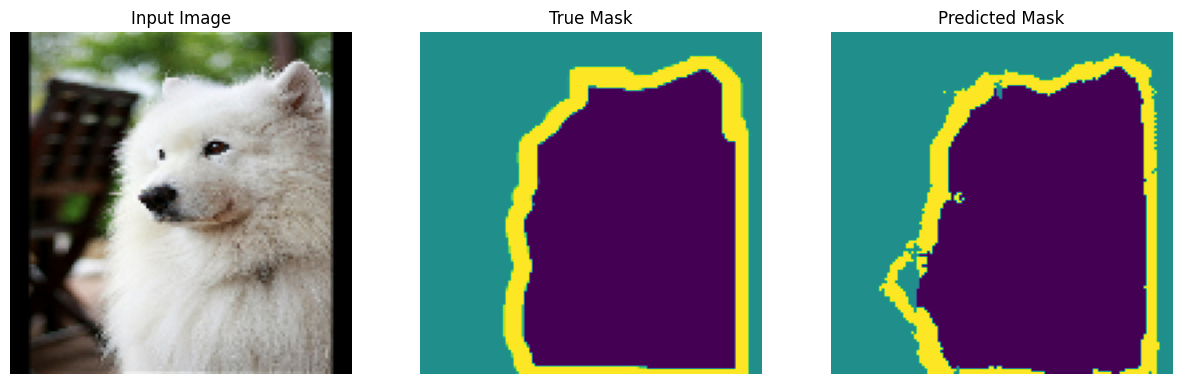

In [26]:
show_predictions(test_batches, 3)

### 옵션 : 불균형 클래스 및 클래스 가중치
- 시맨틱 분할 데이터세트는 불균형이 심할 수 있다.
- 즉, 특정 클래스 픽셀이 다른 클래스의 픽셀보다 이미지 내부에 더 많이 존재

In [27]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


- 가중치를 직접 구현
- 샘플 가중치를 사용하여 작업을 수행
- `(data, label)` 쌍 외에 `Model.fit`는 `(data, label, sample_weight)` 트리플도 허용
- Keras `Model.fit`은 `sample_weight`를 손실 및 메트릭으로 전파하며 `sample_weight` 인수도 허용합니다. 샘플 가중치는 감소 단계 이전의 샘플 값으로 곱해집니다. 예를 들면 다음과 같습니다.

In [28]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

- 따라서 이 튜토리얼을 위한 샘플 가중치를 만들려면 `(data, label)` 쌍을 받아서 `(data, label, sample_weight)` 트리플을 반환하는 함수가 필요합니다. 여기서 `sample_weight`는 각 픽셀에 대한 클래스 가중치를 포함하는 1채널 이미지입니다.

- 가장 간단한 구현은 레이블을 `class_weight` 목록에 대한 인덱스로 사용하는 것입니다.

In [29]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

- 결과 데이터세트 요소에는 각각 3개의 이미지가 포함

In [30]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

-가중치가 적용된 데이터세트에서 모델을 훈련 가능

In [31]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [32]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 7s 125ms/step - loss: 0.2371 - accuracy: 0.7090
